In [1]:
import json
import os
import shutil
import cv2
import threading
import numpy as np
from imantics import Polygons, Mask
import logging
from tqdm import tqdm

In [13]:
import torch
def box_iou(box1, box2, eps=1e-7):
    # https://github.com/pytorch/vision/blob/master/torchvision/ops/boxes.py
    """
    Return intersection-over-union (Jaccard index) of boxes.
    Both sets of boxes are expected to be in (x1, y1, x2, y2) format.
    Arguments:
        box1 (Tensor[N, 4])
        box2 (Tensor[M, 4])
    Returns:
        iou (Tensor[N, M]): the NxM matrix containing the pairwise
            IoU values for every element in boxes1 and boxes2
    """

    # inter(N,M) = (rb(N,M,2) - lt(N,M,2)).clamp(0).prod(2)
    (a1, a2), (b1, b2) = box1.unsqueeze(1).chunk(2, 2), box2.unsqueeze(0).chunk(2, 2)
    inter = (torch.min(a2, b2) - torch.max(a1, b1)).clamp(0).prod(2)

    # IoU = inter / (area1 + area2 - inter)
    return inter / ((a2 - a1).prod(2) + (b2 - b1).prod(2) - inter + eps)

In [14]:
box1 = torch.tensor([[1,1,3,3]])
box2 = torch.tensor([[2,2,4,4]])

tensor([[0.1429]])

In [ ]:
import os
from collections import defaultdict
label_root = './data/yolov5/Train/labels'
areas = []
resize = 1024
total_areas = [3384*3340 , 1254*1244]
ratios = [r / (resize ** 2) for r in total_areas]
class_names = ['powder_uncover', 'powder_uneven', 'scratch']

areas_count = defaultdict(list)
for f in os.listdir(label_root):
    path = os.path.join(label_root, f)
    with open(path, 'r') as f:
        lines = f.readlines()
    for line in lines:
        w, h = line.split(' ')[-2:]
        cls_idx = int(line.split(' ')[0])

        w, h= float(w), float(h)
        if cls_idx <= 1:
            total_area = total_areas[0]
            ratio = ratios[0]
        else:
            total_area = total_areas[1]
            ratio = ratios[1]
        area = w * h #(w * h * total_area) / ratio
        areas.append(area)
        areas_count[cls_idx].append(area)

In [30]:
import os
from collections import defaultdict
label_root = './data/yolov5/Train/labels'
areas = []
resize = 1024
total_areas = [3384*3340 , 1254*1244]
ratios = [r / (resize ** 2) for r in total_areas]
class_names = ['powder_uncover', 'powder_uneven', 'scratch']

areas_count = defaultdict(list)
for f in os.listdir(label_root):
    path = os.path.join(label_root, f)
    with open(path, 'r') as f:
        lines = f.readlines()
    for line in lines:
        w, h = line.split(' ')[-2:]
        cls_idx = int(line.split(' ')[0])

        w, h= float(w), float(h)
        if cls_idx <= 1:
            total_area = total_areas[0]
            ratio = ratios[0]
        else:
            total_area = total_areas[1]
            ratio = ratios[1]
        area = w * h #(w * h * total_area) / ratio
        areas.append(area)
        areas_count[cls_idx].append(area)

In [52]:
areas = np.array(areas)
mean = np.mean(areas)
std = np.std(areas)
np.count_nonzero(areas_count[0] < (mean))

184

In [53]:
mean - std / 2

0.012371491731924311

In [45]:
std

0.04562134803905578

In [35]:
np.count_nonzero(np.array(areas) < np.array(areas).mean())

442

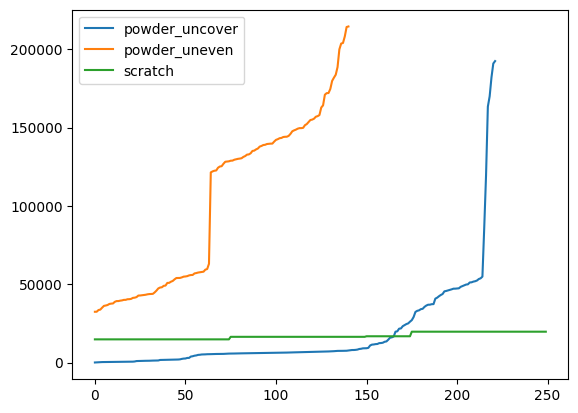

In [24]:
import matplotlib.pyplot as plt
import numpy as np
for cls_idx, count in areas_count.items():
    count.sort()
    plt.plot(range(len(count)), count, label=class_names[cls_idx])
plt.legend()
plt.show()

In [18]:
import matplotlib.pyplot as plt
import numpy as np
areas = np.array(areas)

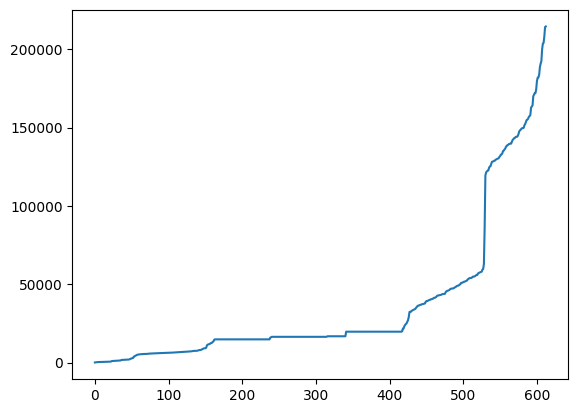

In [19]:
plt.plot(range(len(areas)), areas)

In [2]:
def setup_logging(level='info', log_file=None):
    """Initialize logging settings."""
    import logging
    from logging import basicConfig

    from rich.console import Console
    from rich.logging import RichHandler

    if isinstance(level, str):
        level = level.upper()

    handlers = []
    if log_file:
        fh = logging.FileHandler(log_file)
        formatter = logging.Formatter(
            '%(asctime)s %(levelname)s %(message)s %(filename)s:%(lineno)d'
        )
        fh.setFormatter(formatter)
        handlers.append(fh)

    console = Console(width=160)
    handlers.append(RichHandler(console=console))
    basicConfig(level=level, format='%(message)s',
                datefmt='[%X]', handlers=handlers)
setup_logging()

In [3]:
class_names = ['powder_uncover', 'powder_uneven', 'scratch']
class_mapping = {name : i for i, name in enumerate(class_names)}

logger = logging.getLogger()

def copy_file(src: str, dst: str) -> None:
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    if not os.path.exists(dst):
        shutil.copy(src , dst)

def gen_yolov5_txt(origin_h: float , 
                    origin_w: float,
                    label_file_path: str, 
                    txt_file_name: str, 
                    txt_file_root: str, 
                    cls_idx: int):
    with open(label_file_path, 'r') as f:
        data = json.load(f)

    os.makedirs(txt_file_root, exist_ok=True)
    rects = [label['points'] for label in data['shapes']]
    lines = []
    for rect in rects:
        lt_x, lt_y = rect[0] # left top x, y
        rb_x, rb_y = rect[1] # right bottom x, y
        center_x = ((lt_x + rb_x) / 2) / origin_w
        center_y = ((lt_y + rb_y) / 2) / origin_h
        w, h = (rb_x - lt_x) / origin_w, (rb_y - lt_y) / origin_h
        w = abs(w)
        h = abs(h)
        # if w < 0 or h < 0:
        #     print(label_file_path)
        #     logger.warning("W or h is less than 0")
        #     continue
        line = [int(cls_idx), center_x, center_y, w, h]
        line = [str(element) for element in line]
        line = ' '.join(line) + '\n'
        lines.append(line)
    with open(os.path.join(txt_file_root, txt_file_name), 'w') as f:
        f.writelines(lines)


for split_name in ['Train', 'Val']:
    data_root = os.path.join('./origin_data', split_name)
    new_data_root = os.path.join('./yolov5_data', split_name)

    name_idx = 0
    for cls_idx, cls in enumerate(class_names):
        cls_root = os.path.join(data_root, cls)
        for name in tqdm(os.listdir(os.path.join(cls_root, 'image'))):
            # Rename and move image
            new_name = f'{name_idx}.png'
            copy_file(os.path.join(cls_root, 'image', name), 
                    os.path.join(new_data_root, 'images', new_name))

            im = cv2.imread(os.path.join(new_data_root, 'images', new_name))
            h, w, c = im.shape
            txt_file_name = f'{name_idx}.txt'
            txt_file_root = os.path.join(new_data_root, 'label')
            label_file_path = os.path.join(cls_root, 'label', name.split('.')[0] + '.json')
            gen_yolov5_txt(h, w, label_file_path, txt_file_name, txt_file_root, cls_idx)
            name_idx += 1

100%|██████████| 50/50 [00:01<00:00, 40.59it/s]
